## Inject Bugs & Run Experiment

![Inject Bugs & Run Experiment](./pic/RL_Testing.drawio.png)

#### Frozenlake Testbed Experiment

- Find log files in RLTestig/logs/frozenlake

In [ ]:
import bug_lib as BL


bug_version_list = [
    [],
    [0],
    [1],
    [2],
    [3],
    [4],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15],
]

bug_version = []


In [ ]:
BL.cover_then_inject_bugs(bug_version)
# After this step, Restart the ipynb environment

In [ ]:
import frozenlake.testing_SB3_Frozenlake as Frozenlake_Experiment
Frozenlake_Experiment.main(bug_version=bug_version, rounds=10, epochs=300, model_type='ppo')

#### Mountaincar Testbed (continous) Experiment

- Find log files in RLTestig/logs/mountaincar

In [ ]:
import bug_lib as BL


bug_version_list = [
    [],
    [5],
    [6],
    [7],
    [8],
    [10],
    [11],
    [12],
    [13],
    [14],
    [15]
]

bug_version = [31]

In [ ]:
BL.cover_then_inject_bugs(bug_version)

In [ ]:
import mountaincar.testing_SB3_Mountaincar as Mountaincar_Experiment


Mountaincar_Experiment.main(bug_version=bug_version, rounds=10, epochs=700, model_type='a2c', max_steps=500)

## Validation Part

In [3]:
import log_parser
import pandas as pd
import scipy.stats as stats
from scipy.stats import linregress
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import config_parser
from scipy.stats import binomtest

C:\Users\hkson\AppData\Local\Temp\ipykernel_17320\4259270584.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
def find_converge_point(data, n, epsilon):
    """
    n: the minimum number of points after the converge point that follows epsilon converge rule.
    """

    #calculate step differnece
    data = np.array(data)
    shifted_data = np.roll(data, 1)
    shifted_data[0] = 0
    step_diff = abs(data - shifted_data)

    #Find the epsilon converge points
    epsilon_converge = np.zeros_like(step_diff)
    for i in range(2, len(step_diff)):
        if step_diff[i] < step_diff[i - 1] * epsilon:
            epsilon_converge[i] = 1

    converge_point = -1
    temp = 0
    for i in range(2, len(epsilon_converge)):
        if epsilon_converge[i] == 1:
            temp += 1
        if temp > n:
            converge_point = i - n + 1
            break

    return converge_point

def find_converge_break_point(data, converge_point, delta, n):
    """
    n: the maximum number of continuous outlier points after the converge point that we can tolerate.
    """

    converge_break_point = -1
    
    counter = 0
    continuous = False
    for i in range(converge_point + 1, len(data)):
        #Find continuous break point
        if data[i] - data[i - 1] > delta:
            if not continuous:
                continuous = True
            counter += 1
        elif continuous:
            continuous = False
            counter = 0

        if counter >= n:
            print(converge_point, converge_break_point)
            converge_break_point = i - n + 1
            break
    
    return converge_break_point

In [9]:
root_dir = config_parser.parserConfig()['root_dir']
    
def analyze_data_trend_and_convergence_v2(data, trend_threshold=0, convergence_range=20, fluctuation_range=0.1, convergence_window_ratio=0.1, negative_fluctuation_limit=0.05, show=False, title="trend", confidence_level=0.95):
    # 计算整个数据集趋势线的斜率
    slope, _, _, _, _ = linregress(range(len(data)), data)
    upwards_trend = slope > trend_threshold
    
    # 确定收敛窗口的大小为数据点总数的一定比例
    window_size = max(int(len(data) * convergence_window_ratio), 1)
    
    converge_point = find_converge_point(data, window_size, 0.9)
    converge_break_point = -1
    lower_bound = data[converge_point] - 0.1

    if converge_point != -1:
        converge_break_point = find_converge_break_point(data, converge_point, 0.1, 5)

    # 可视化
    # print(upwards_trend, no_large_negative_fluctuation, no_large_negative_fluctuation and upwards_trend)
    if show:
        plt.figure(figsize=(10, 5))
        plt.plot(data, marker='o', label='data')
        plt.plot(range(len(data)), [slope * x + data[0] for x in range(len(data))], 'r--', label=f'slope (slope={slope:.2f})')
        if converge_point != -1:
            plt.axvline(x=converge_point, color='g', linestyle='--', label='converge_point')
            plt.axhline(y=lower_bound, color='orange', linestyle='--', label='confidence_bottom')
            if converge_break_point != -1:
                plt.axvline(x=converge_break_point, color='r', linestyle='--', label='converge_break_point')
        plt.title(title)
        plt.legend()
        plt.grid(True)
        plt.show()

    return (upwards_trend, converge_point == -1)

def linear_regression_with_convergence_check(data, title='Data Trend Analysis', window_size=5, threshold=0.05, show=False):
    
    # 将数据转换成Pandas Series对象
    series = pd.Series(data)

    # 计算标准差的移动平均
    rolling_std = series.rolling(window=window_size).std()

    # 判断最后一个窗口的标准差是否小于阈值，确定是否收敛
    is_converged = rolling_std.iloc[-1] < threshold

    # 使用线性回归判断趋势
    slope, intercept, r_value, p_value, std_err = linregress(range(len(data)), data)
    
    if show:
        # 绘制数据和趋势线以及移动标准差
        plt.figure(figsize=(12, 6))
        
        # 绘制原始数据和趋势线
        plt.subplot(1, 2, 1)
        plt.plot(data, label='Original Data', marker='o')
        plt.plot(range(len(data)), intercept + slope * np.asarray(range(len(data))), 'r', label=f'Trend Line: slope={slope:.2f}')
        plt.legend()
        plt.title(title)
        
        # 绘制移动标准差
        plt.subplot(1, 2, 2)
        plt.plot(rolling_std, label='Moving Standard Deviation')
        plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold}')
        plt.legend()
        plt.title('Data Convergence Check')
        
        plt.tight_layout()
        plt.show()

    # 如果斜率大于或等于0，并且数据收敛，则返回True
    if slope < 0 or not is_converged:
        return "false"
    else:
        return "true"

    

def test_true_proportion(num_samples, num_true, sig_level=0.05, expected_prob=0.95):
    """
    对观察到的 'true' 样本数进行二项检验。

    :param num_samples: 样本总数
    :param num_true: 观察到的 'true' 样本数
    :param sig_level: 显著性水平（默认为 0.05）
    :param expected_prob: 预期成功概率（默认为 0.5）
    :return: p 值和是否显著
    """
    # 计算二项检验的 p 值
    p_value = binomtest(k=num_true, n=num_samples, p=expected_prob, alternative='greater')

    # 判断是否显著
    is_significant = p_value < sig_level

    return p_value, is_significant


def bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]
    print(bug_free_log_list)

    result = []
    accuracy_result = []
    convergance_result = []
    for path in bug_free_log_list:
        # print(log_parser.parse_log_file(path))
        data = log_parser.parse_log_file_fuzzy(path)
        if len(data)> 0:
            # temp = linelar_regression(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_check(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_slop_check(data, title=path, show=show_fig)
            temp = analyze_data_trend_and_convergence_v2(data, title=path, show=show_fig)
        # result.append(temp)
        accuracy_result.append(temp[0])
        convergance_result.append(temp[1])
        result.append(temp[0] and temp[1])

    # p_value = binomtest(result.count('true'), len(result), alternative='greater')
    # print(p_value)
    print(binomtest(accuracy_result.count(True), len(result), alternative='greater'))
    print(binomtest(convergance_result.count(True), len(result), alternative='greater'))
    print(binomtest(result.count(True), len(result), alternative='greater'))

    
def bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_fig=False):
    # 使用 Path.rglob() 获取所有子文件
    # '**/*' 表示匹配所有的文件和文件夹, 如果只想匹配文件, 使用 '**/*.*'
    bug_free_log_list = [file for file in bug_free_log_path.rglob('*') if file.is_file()]

    print(bug_free_log_list)

    # accuracy_list = []
    # 打印所有文件路径
    result = []
    accuracy_result = []
    convergance_result = []
    for path in bug_free_log_list:
        data = log_parser.parse_mountaincar_log_file(path)
        if len(data) > 0:
            # temp = linelar_regression(data, title=path, show=show_fig)
            # temp = linear_regression_with_convergence_slop_check(data, title=path, show=show_fig)
            temp = analyze_data_trend_and_convergence_v2(data, title=path, show=show_fig, convergence_range= 20)
        accuracy_result.append(temp[0])
        convergance_result.append(temp[1])
        result.append(temp[0] and temp[1])
    
    
    '''
    在进行二项检验时，零假设（null hypothesis）通常是观察到的成功次数与随机变化相一致，即成功的概率等于 expected_prob。如果实际观察到的成功次数显著高于（或低于）这个期望成功概率，那么您可能会得到一个很小的 p 值，从而拒绝零假设。
    '''
    # p_value = binomtest(result.count('true'), len(result), alternative='greater')
    # print(p_value)
    print(binomtest(accuracy_result.count(True), len(result), alternative='greater'))
    print(binomtest(convergance_result.count(True), len(result), alternative='greater'))
    print(binomtest(result.count(True), len(result), alternative='greater'))

[WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_0'), WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_1'), WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_2'), WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_3'), WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_4'), WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_5'), WindowsPath('C:/Users/hkson/research/SB3 TEST/stable-baselines3-testing-new/RLTesting/logs/Frozenlake/ppo/[7]/time_2024-03-07[7]round_6'), WindowsPath('C:/Users/hkso

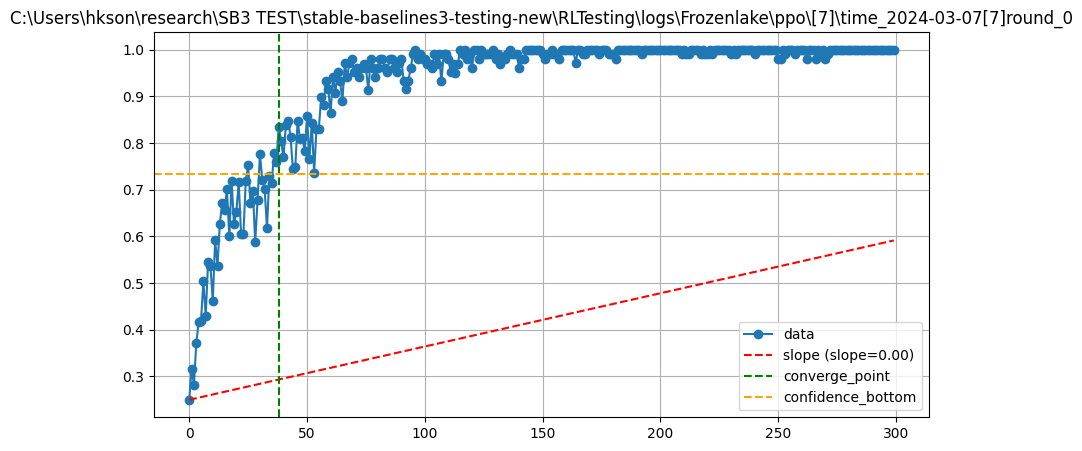

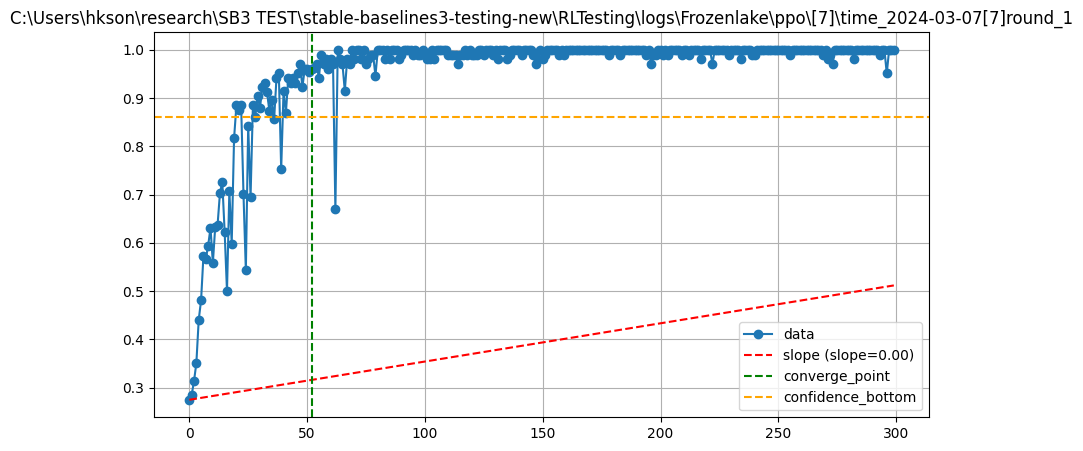

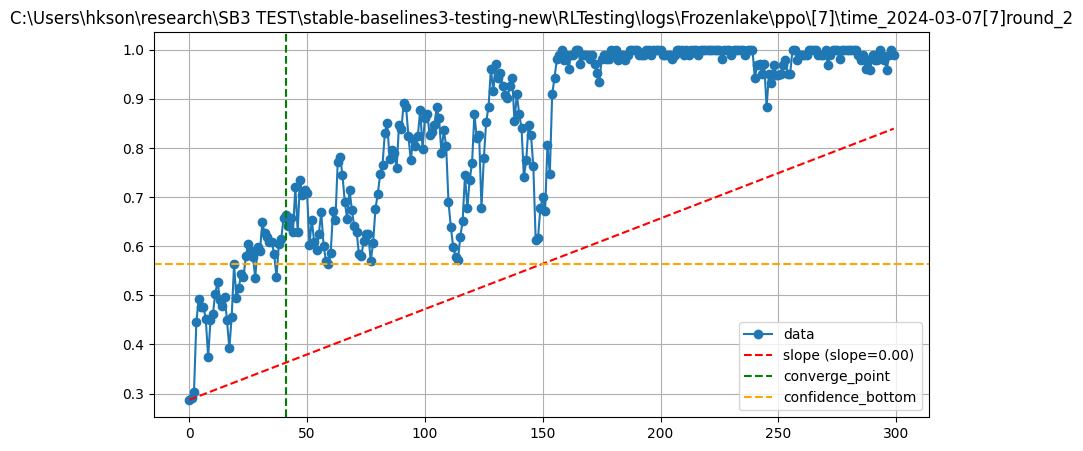

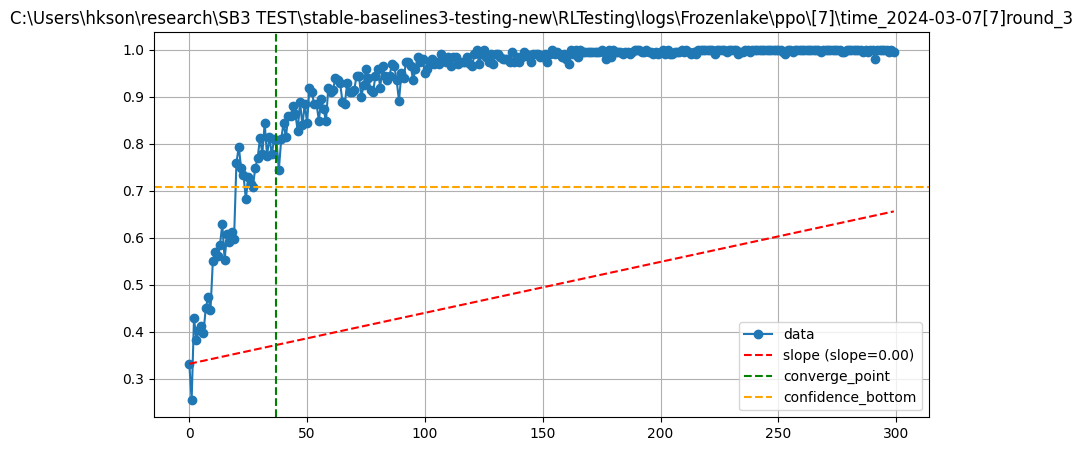

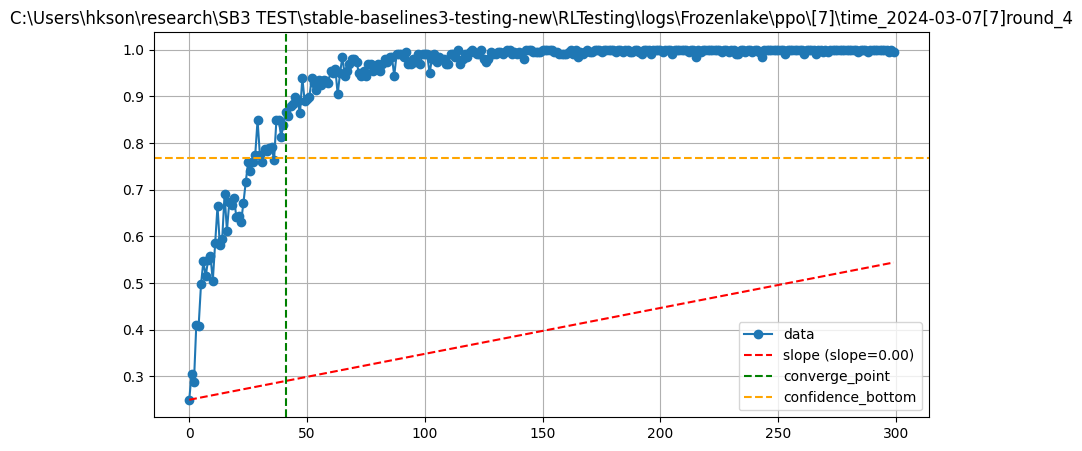

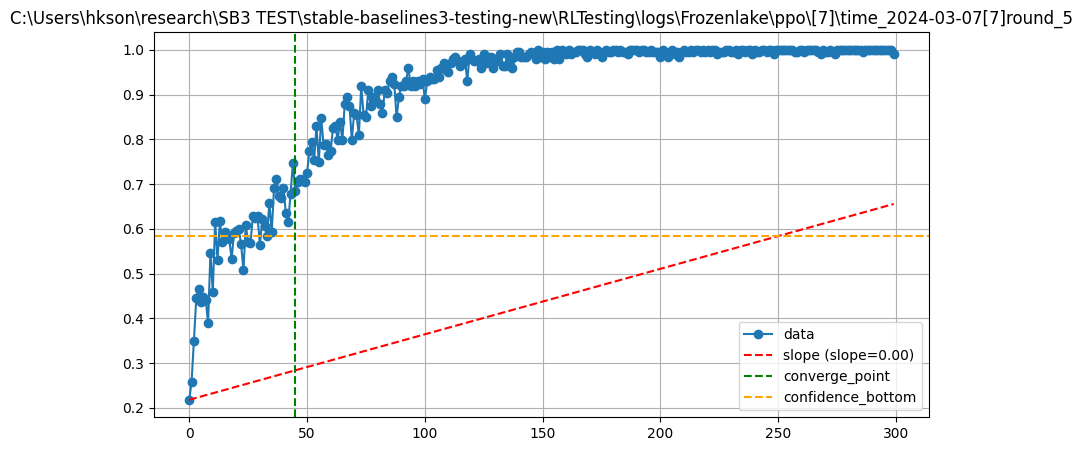

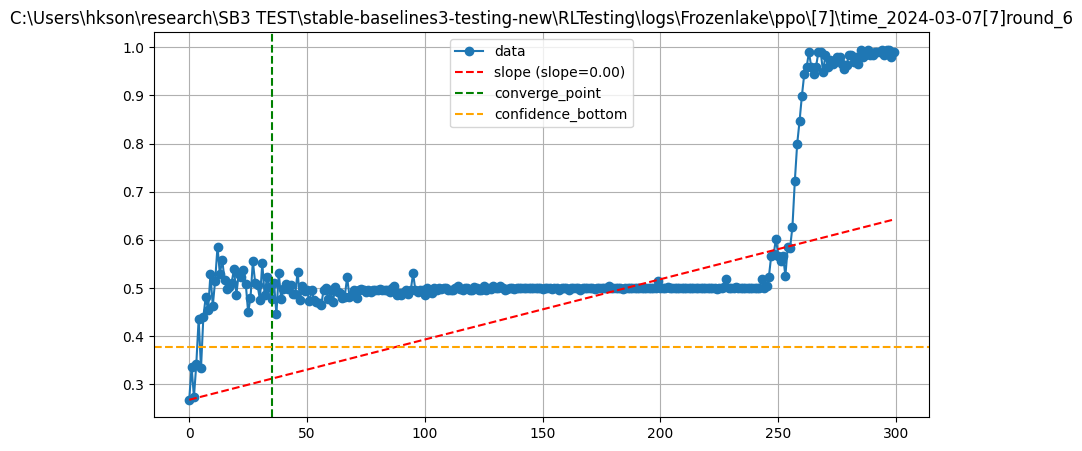

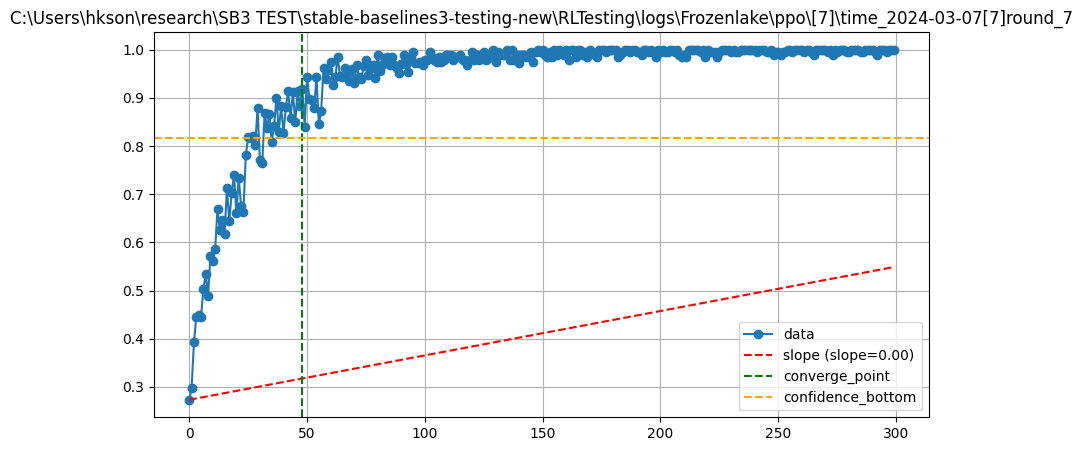

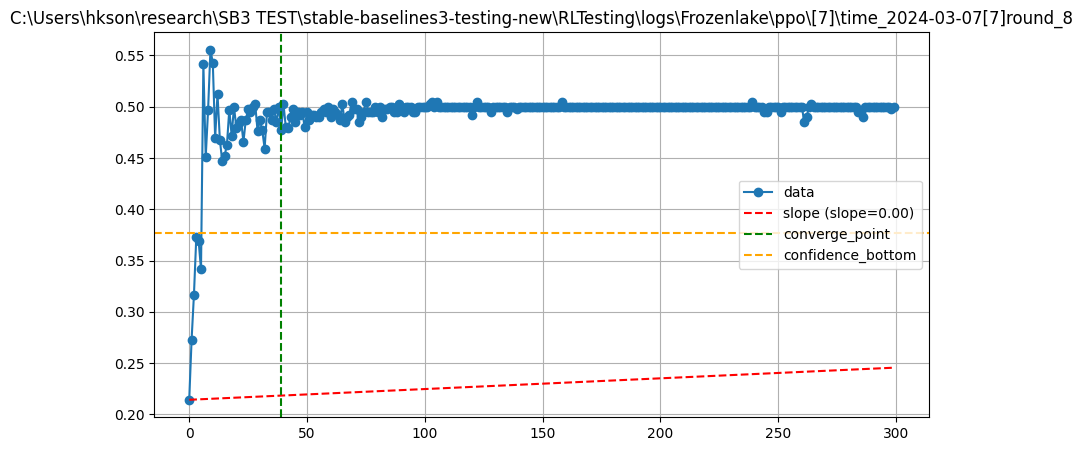

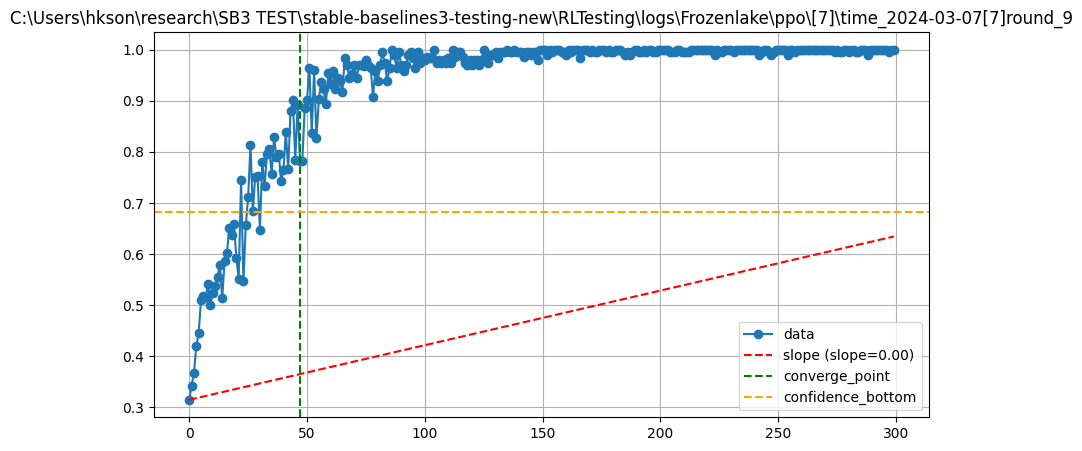

BinomTestResult(k=10, n=10, alternative='greater', statistic=1.0, pvalue=0.0009765625)
BinomTestResult(k=0, n=10, alternative='greater', statistic=0.0, pvalue=1.0)
BinomTestResult(k=0, n=10, alternative='greater', statistic=0.0, pvalue=1.0)


In [10]:
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[39]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'a2c', '[]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'sac', '[]')), show_fig=True)

# bug_list = [0, 1, 2, 4, 6, 9, 10, 16, 17, 18, 19, 20, 21, 22, 23]
# bug_list = [24, 25, 26, 27, 28, 29, 30, 31, 32]
bug_list = [25, 26, 27, 28, 33, 34, 35, 36, 37, 38, 39]

bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[7]')), show_fig=True)
# for bug in bug_list:
#     bug = '[' + str(bug) + ']'
#     print(bug)
#     bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'ppo', bug)), show_fig=False)


In [ ]:
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[]')), show_fig=False)
# bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[]')), show_fig=True)
# bin_test_mountaincar(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Mountaincar', 'a2c', '[]1')), show_fig=False)


'''-------------------up bugfree--------------------down buggy----------------------'''



bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[0]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[1]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[2]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[4]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[6]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[9]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[10]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[16]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[17]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[18]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[19]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[20]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[21]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[22]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[23]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'dqn', '[24]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[7]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'ppo', '[9]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[24]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[25]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[26]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[27]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[28]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[29]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[30]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[31]')), show_fig=False)
bin_test_frozenlake(bug_free_log_path = Path(os.path.join(root_dir, 'RLTesting', 'logs', 'Frozenlake', 'a2c', '[32]')), show_fig=False)


